# Final Project: 17k App Store Strategy Games Analysis
Samuel Folledo's final project for [DS1.1](https://github.com/Make-School-Courses/DS-1.1-Data-Analysis)

Thank you Tristan for the [17K Mobile Strategy Games
Every strategy game on the Apple App Store Dataset](https://www.kaggle.com/tristan581/17k-apple-app-store-strategy-games) collected on the 3rd of August 2019

In [320]:
# Pandas is a library for basic data analysis
import pandas as pd

# NumPy is a library for advanced mathematical computation
import numpy as np

# MatPlotLib is a library for basic data visualization
import matplotlib.pyplot as plt

# SeaBorn is a library for advanced data visualization
import seaborn as sns

FILEPATH = "appstore_games.csv"
df = pd.read_csv(FILEPATH, 
                 na_values = ['#ERROR!', "nan", "NaN", "Nan", "NA", "NA / NaN"], encoding="utf-8"
#                  names= ['Name', 'Average User Rating',
#        'User Rating Count', 'Price', 'In-app Purchases', 'Description',
#        'Developer', 'Age Rating', 'Languages', 'Size', 'Primary Genre',
#        'Genres', 'Original Release Date', 'Current Version Release Date']
                )
df.info() #17007, 18

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 18 columns):
URL                             17007 non-null object
ID                              17007 non-null int64
Name                            17007 non-null object
Subtitle                        5261 non-null object
Icon URL                        17007 non-null object
Average User Rating             7561 non-null float64
User Rating Count               7561 non-null float64
Price                           16983 non-null float64
In-app Purchases                7683 non-null object
Description                     17007 non-null object
Developer                       17007 non-null object
Age Rating                      17007 non-null object
Languages                       16947 non-null object
Size                            17006 non-null float64
Primary Genre                   17007 non-null object
Genres                          17007 non-null object
Original Release Date       

## Clean the dataframe
1. removed the following columns: URL, ID, Subtitle, Icon URL 
2. turn Age Rating from str type (4+, 9+, 12+ 17+) to int type
3. specify data types

In [3]:
#1.
to_drop = ["URL", "ID", "Subtitle", "Icon URL"]
df.drop(to_drop, inplace=True, axis=1)

#2
df['Age Rating'] = df.apply(lambda x: x['Age Rating'].replace('+', ''), axis=1) #remove all "+" in Age Rating to turn it into an int type
df['Age Rating'] = df['Age Rating'].astype(int)
# print(df['Age Rating'].value_counts())

#Specify data type of non-strings
df['Name'] = df['Name'].astype(str)
df["Name"].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
# df.Lastname.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
# df[df['Average User Rating']].value_counts()

# df.shape
# for name in df.Name.unique():
#     if len(name) > 50: #prin
#         print("===",name)

In [176]:
# df[df["Name"]].unique()
# df['Name'] = df['Name'].astype(str)
len(df[df['Languages'] != "EN"].values)
df.dtypes

Name                             object
Average User Rating             float64
User Rating Count               float64
Price                           float64
In-app Purchases                 object
Description                      object
Developer                        object
Age Rating                        int64
Languages                        object
Size                            float64
Primary Genre                    object
Genres                           object
Original Release Date            object
Current Version Release Date     object
dtype: object

## Questions to Answer
- Does supporting multiple languages drive more user? or drive better rating?
- Probability of a game getting downloaded based on prices
- What characteristics does top games have in common?
- What did the top 5 most released developers have in common?
- Does age rating affect users rating?

### Helper functions

In [322]:
def conditional_prob(df, column1, value1, column2):
    '''Create a dictionary of "column2_val : percentage" '''
    probabilities = {}
#     column1_is_value1 = df[df[column1] == value1]
    column2_values = set(df[column2].dropna().values) #possible values for target_column
    for column2_value in column2_values: #for each value in target's values
        probabilities[column2_value] = len(df[ (df[column1] == value1) & (df[column2] == column2_value)]) / len(df[df[column1] == value1]) #len(col_1 == value_1 and col_2 == val_2) / len(col_1 == val_1)
    return probabilities

def df_from_col_ratio(df, to_ratio_col, x_col):
    '''Get df with ratio of column based on all possible values or x_col and put it in a line graph'''
    to_ratio_values = [] #unique values of to_ratio_col from df
    x_col_values_dic = {} #{"Promoter": [], "Passive": [], "Detractor":[]} 
    for to_ratio_value in sorted(df[to_ratio_col].dropna().unique()): #loop through each unique values of to_ratio_col
        x_col_ratio_dic = conditional_prob(df, to_ratio_col, to_ratio_value, x_col)
        to_ratio_values.append(to_ratio_value) #append current location
        for key, value in x_col_ratio_dic.items(): #loop through each key,value pairs in dic received from conditional_prob
            if key in x_col_values_dic: #if dic's key has values already
                x_col_values_dic[key].append(value) #if key exist, append value to our list's key
            else:  #if dic's key is none...
                x_col_values_dic[key] = [value] #create the array with our value
    #Turn dic and array to dataframe
    df_new = pd.DataFrame(x_col_values_dic, index=to_ratio_values)
    return df_new


def graph_conditional_prob(df, column1, value1, column2):
    '''get conditional probability and graph of column2 base on column1's value1'''
    probabilities = {}
    column1_is_value1 = df[df[column1] == value1] #all column1 == value1
    column2_values = set(df[column2].dropna().values) #possible values for target_column #Names
    column2_names = []
    column2_percents = []
    column2_explode = [] #explode the biggest percent
    for column2_value in column2_values: #for each value in target's values
        column2_names.append(column2_value) #append name
        #get column2's percent
        c2_percent = len(df[ (df[column1] == value1) & (df[column2] == column2_value)]) / len(df[df[column1] == value1])
        column2_percents.append(c2_percent)
        probabilities[column2_value] = c2_percent
    max_value = max(column2_percents) #get max value that we will explode
    max_index = column2_percents.index(max_value) #get max_value's index
    for i in range(len(column2_percents)): #populate column2_explode
        if i == max_index: #explode the index with max value
            column2_explode.append(0.1)
            continue
        column2_explode.append(0)
    #Begin plotting
    fig1, ax1 = plt.subplots()
    ax1.pie(column2_percents, explode=column2_explode, labels=column2_names, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(column1+": "+str(value1)+" ("+str(len(column1_is_value1))+")") #assign plot's title
    plt.show()
    return probabilities
# for rating in df["Average User Rating"].dropna().unique():
#     graph_conditional_prob(df, "Average User Rating", rating, "Price")

#function to create a pie chart
def pie_chart_column(df, col_name):
    '''Create a pie chart from a column. Recommended for columns with 2-5 unique values'''
    col_values = df[col_name].dropna().unique()
    col_percentage = []
    for index, value in enumerate(col_values):
        value_count = len(df[(df[col_name] == value)])
        val_percentage = value_count / len(df) #get percentage; by dividing num of rows being value by the total length of dataset
        col_percentage.append(val_percentage) #append percentage
        col_values[index] += " "+str(value_count)
    #Begin plotting
    fig1, ax1 = plt.subplots()
    ax1.pie(col_percentage, labels=col_values, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(col_name+" Ratio: Out Of "+str(len(df["Price"].dropna()))+" Apps") #assign plot's title
    plt.show()
    
def custom_hist(ls, interval):
    hist_ls_dict = dict()
    min_ls = np.min(ls)
    max_ls = np.max(ls)
    I = (max_ls - min_ls) / interval #width (x-range) of each bin
    for j in range(int(interval - 1)): #subtract 1 to not go out of range when we j+1
        current_min = min_ls + (I*j) #current minimum
        current_max = min_ls + (I*(j+1)) #j+1 to get current maximum range
        count_from_min_to_max = sum(current_min <= elem < current_max for elem in ls) / len(ls) #get the sum of number of elements greater than min and less than max
        hist_ls_dict[j]= count_from_min_to_max   
    return hist_ls_dict
# age_hist = custom_hist(df['Age'].dropna().values, 16)

# Outlier Functions
import scipy.stats

def find_remove_outlier(data_sample):
    '''Simple remove outliers'''
    # calculate summary statistics
    data_mean, data_std = np.mean(data), np.std(data)
    # define cut-off
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # identify outliers
    outliers = [x for x in data_sample if x < lower or x > upper]
    # remove outliers
    outliers_removed = [x for x in data_sample if x > lower and x < upper]
    return outliers, outliers_removed

def find_remove_outlier_iqr(data_sample):
    '''Finds and remove Quartile 1 and Quartile 3'''
    # calculate interquartile range
    q25, q75 = np.percentile(data_sample, 25), np.percentile(data_sample, 75)
    iqr = q75 - q25
    print(iqr)
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data_sample if x < lower or x > upper]
    # remove outliers
    outliers_removed = [x for x in data_sample if x > lower and x < upper]
    return outliers

y = np.array([-5, 11, 14])
x =  np.concatenate((scipy.stats.norm.rvs(loc=5 , scale=1 , size=100), y))
print(type(x))
print(find_remove_outlier_iqr(x))
print(scipy.stats.iqr(x))

<class 'numpy.ndarray'>
1.4901488313365165
[-5.0, 11.0, 14.0]
1.4901488313365165


### Q1 What are the top free and paid apps?

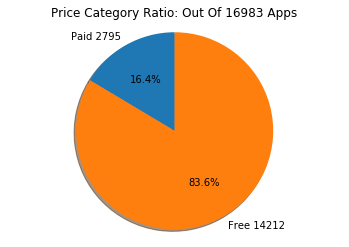

In [178]:
free_games = df[df["Price"] == 0].dropna()
paid_games = df[df["Price"] > 0].dropna()

# function to categorize Free apps from Paid
def get_price_category(price):
    if price == 0:
        return "Free"
    else:
        return "Paid" 

# Create another column named "Price Category" with values of either Free or Paid
df["Price Category"] = df.apply(lambda row: get_price_category(row["Price"]), axis=1)

#function to create a pie chart
def pie_chart_column(df, col_name):
    '''Create a pie chart from a column. Recommended for columns with 2-5 unique values'''
    col_values = df[col_name].dropna().unique()
    col_percentage = []
    for index, value in enumerate(col_values):
        value_count = len(df[(df[col_name] == value)])
        val_percentage = value_count / len(df) #get percentage; by dividing num of rows being value by the total length of dataset
        col_percentage.append(val_percentage) #append percentage
        col_values[index] += " "+str(value_count)
    #Begin plotting
    fig1, ax1 = plt.subplots()
    ax1.pie(col_percentage, labels=col_values, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(col_name+" Ratio: Out Of "+str(len(df["Price"].dropna()))+" Apps") #assign plot's title
    plt.show()

pie_chart_column(df, "Price Category")

### Q2 How are most strategy games rated?

Price Category
Free    AxesSubplot(0.125,0.125;0.775x0.755)
Paid    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Average User Rating, dtype: object

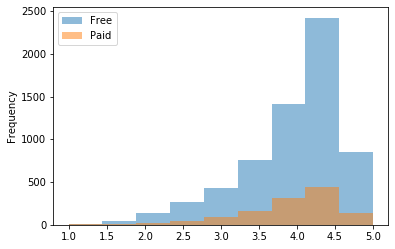

In [179]:
df.groupby('Price Category')['Average User Rating'].plot(bins=9, kind='hist', legend=True, alpha=0.5)

In [180]:
# print("LENGTH=",len(df["Price"].value_counts()))
# df["Price"].value_counts()
pd.crosstab(df['Price'], df['Average User Rating'])

Average User Rating,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
Price,,,,,,,,,
0.00,5,46,136,268,427,758,1413,2423,849
0.99,1,5,8,19,34,57,89,101,38
1.99,2,2,5,7,16,21,51,69,28
2.99,3,3,5,14,15,29,57,98,28
3.99,0,0,1,2,6,13,25,47,11
4.99,2,4,1,4,11,23,46,72,22
5.99,0,0,0,2,1,7,5,11,2
6.99,0,0,0,0,0,7,5,12,2
7.99,0,0,0,0,1,1,3,4,1


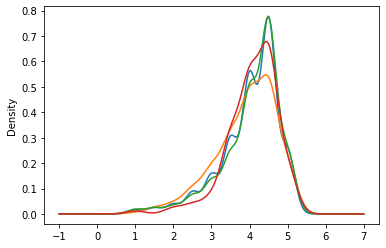

In [8]:
df[df['Price'] > 0]['Average User Rating'].plot(kind='kde') #blue
df[(df['Price'] > 0) & (df['Price'] < 1)]['Average User Rating'].plot(kind='kde') #orange
df[(df['Price'] > 1) & (df['Price'] < 5)]['Average User Rating'].plot(kind='kde') #green
df[(df['Price'] > 5)]['Average User Rating'].plot(kind='kde') #red

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17007 entries, 0 to 17006
Data columns (total 14 columns):
Name                            17007 non-null object
Average User Rating             7561 non-null float64
User Rating Count               7561 non-null float64
Price                           16983 non-null float64
In-app Purchases                7683 non-null object
Description                     17007 non-null object
Developer                       17007 non-null object
Age Rating                      17007 non-null int64
Languages                       16947 non-null object
Size                            17006 non-null float64
Primary Genre                   17007 non-null object
Genres                          17007 non-null object
Original Release Date           17007 non-null object
Current Version Release Date    17007 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 1.8+ MB


Text(0.5, 1.0, 'User Rating')

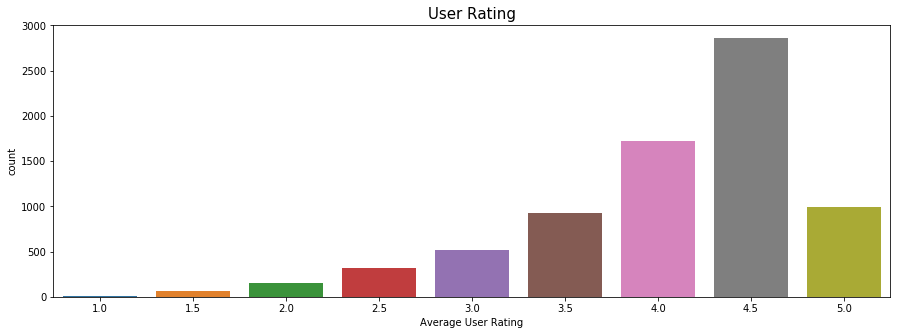

In [23]:
df.info()
n_user_rating = df['Average User Rating']
plt.figure(figsize=(15,5))
sns.countplot(n_user_rating)
plt.title("User Rating",fontsize=15)

## Answer
- Strategy games are popular and loved, and usually receives a 4.5 rating

## Q3 Does supporting multiple languages drive more user? or drive better rating?

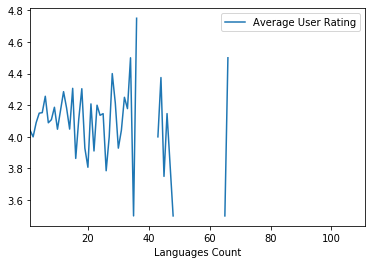

In [6]:
FILEPATH = "appstore_games.csv"
df = pd.read_csv(FILEPATH, 
                 na_values = ['#ERROR!', "nan", "NaN", "Nan", "NA"], encoding="utf-8"
                )

def count_languages_supported(languages):
    '''takes languages supported, create a list separated by , and returns the length of the list'''
    if type(languages) != str: #make sure it is a string
        return 1
    languages_list = languages.split(", ")
    return len(languages_list)
    
df["Languages Count"] = df.apply(lambda row: int(count_languages_supported(row["Languages"])), axis=1)
df["Languages Count"].value_counts()
df.groupby(['Languages Count'])['Average User Rating'].mean().plot(legend=True)

In [324]:
FILEPATH = "appstore_games.csv"
df = pd.read_csv(FILEPATH, na_values = ['#ERROR!', "nan", "NaN", "Nan", "NA"], encoding="utf-8")

def has_multiple_languages(languages):
    '''takes languages supported, create a list separated by , and returns if app re'''
    if type(languages) != str: #make sure it is a string
        return False
    languages_list = languages.split(", ")
    if len(languages_list) > 1:
        return True
    return False

# Create Multiple Languages column and apply function
df["Multiple Languages"] = df.apply(lambda row: int(has_multiple_languages(row["Languages"])), axis=1)

print(df["Multiple Languages"].value_counts())
print(df['Multiple Languages'].value_counts(normalize=True))
df.groupby(['Multiple Languages'])['Average User Rating', 'User Rating Count'].mean()

0    12626
1     4381
Name: Multiple Languages, dtype: int64
0    0.7424
1    0.2576
Name: Multiple Languages, dtype: float64


,Average User Rating,User Rating Count
Multiple Languages,,
0,4.041494,1560.013238
1,4.100200,6842.182400


### Z-Test Null Hypothesis
Does Mutiple Languages result in higher User Rating Count?
- Z-Test instead of T-Test because length of data is more than 30

In [325]:
from scipy.stats import norm
import numpy as np
import scipy.stats
import numpy as np, scipy.stats as st

def mean_confidence_interval(data, confidence=0.95):
    '''Computes the alpha of a given data'''
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

#alternate of the function above
alternate_confidence = st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data)) #calculating the 95% confidence interval of the mean of array data array

def z_t_null_hypothesis(data_sample, mu, sigma, significant_level):
    'Run Z-Test or T-Test'
    # If sigma is known, calculate using the z-test
    if sigma:
        z_score = (np.mean(data_sample)-mu)/(sigma/np.sqrt(len(data_sample)))
        print(f"Z:{z_score} = {np.mean(data_sample)-mu} / {sigma/np.sqrt(len(data_sample))}")
        p = scipy.stats.norm.sf(abs(z_score))*2
    # If the data_sample is greater than 30, calculate using the z-test
    elif len(data_sample) > 30:
        z_score = (np.mean(data_sample)-mu)/(np.std(data_sample)/np.sqrt(len(data_sample)))
        p = scipy.stats.norm.sf(abs(z_score))*2
    # otherwise, calculate using the t-test
    else:
        t, p = stats.ttest_1samp(data_sample, mu)
    
    print(f"P={p}")
    if p < significant_level:
        print('reject null hypothesis')
        
    else:
        print('accept null hypothesis')
        
# Begin Test
data = df[(df["Average User Rating"] > 4) & (df["User Rating Count"] > 10000)]["Multiple Languages"]
data_sample = data.values #get values in this column as an array

# Create parameters
N = len(df) # N = size of population 
mu = len(data) / len(df)
sigma = data.std() # 𝞼 = standard deviation (std) for Scenario A
confidence_level = mean_confidence_interval(data, confidence=0.95)
alpha = 1 - confidence_level[1] # 𝛼 = statistical significance level; alpha = 1 - significance level

# Display results
print(f"N={N}, data={len(data_sample)}, mu={mu}, sigma={sigma}, alpha={alpha}")
z_t_null_hypothesis(data, mu, sigma, alpha) #alpha of 0.05


N=17007, data=271, mu=0.01593461515846416, sigma=0.48890938866409933, alpha=0.44961523313515306
Z:19.964270582295818 = 0.5929214734024214 / 0.029699130301721124
P=1.1266056625349428e-88
reject null hypothesis


Text(0.5, 1.0, 'Did High Rated and High Rating Count Apps Supported More than 1 Languages?')

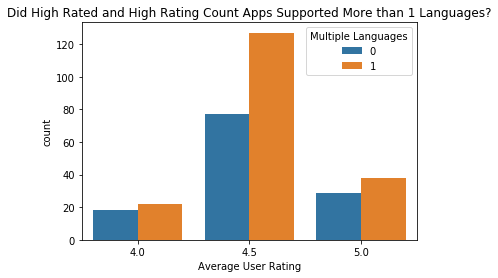

In [256]:
dataa = df[(df["Average User Rating"] >= 4) & (df["User Rating Count"] > 10000)]
plot = sns.countplot(x="Average User Rating", hue="Multiple Languages", data=dataa)
plot.set_title("Did High Rated and High Rating Count Apps Supported More than 1 Languages?")

### Answer
- Only 26% of games in this dataset supports multiple languages
- Apps that supports multiple languages on average have significantly more User Rating Count than apps that supports one language
- Hypothesis Testing needs some clarification and further research

#### Side Note:
To easily support multiple languages and have those painful tasks automated checkout my [StringsUtility](https://github.com/SamuelFolledo/StringsUtility)

## Q4 What did the top 5 most released developers have in common?

In [36]:
# most_released_devs is an array of Developers who uploaded more than 70 apps
most_released_devs = df[df["Developer"].isin(df["Developer"].value_counts().index[df["Developer"].value_counts().gt(70)])]["Developer"] #get the value counts of Developers that has more than 70 apps
print(most_released_devs.unique())

top_5_devs_df = df[df['Developer'].isin(most_released_devs)]
top_5_devs_df.groupby(['Developer'])['Average User Rating', 'User Rating Count'].mean()

['GabySoft' 'Tapps Tecnologia da Informa\\xe7\\xe3o Ltda.'
 'NetSummit Enterprises, Inc.' 'Netsummit Marketing, Inc.' 'Vikash Patel']


,Average User Rating,User Rating Count
Developer,,
GabySoft,4.233333,355.533333
"NetSummit Enterprises, Inc.",2.882353,15.529412
"Netsummit Marketing, Inc.",3.388889,13.055556
Tapps Tecnologia da Informa\xe7\xe3o Ltda.,4.417391,2390.000000
Vikash Patel,1.500000,5.000000


Text(0.5, 1.0, 'Count of Apps uploaded by the developers with the most shipped apps')

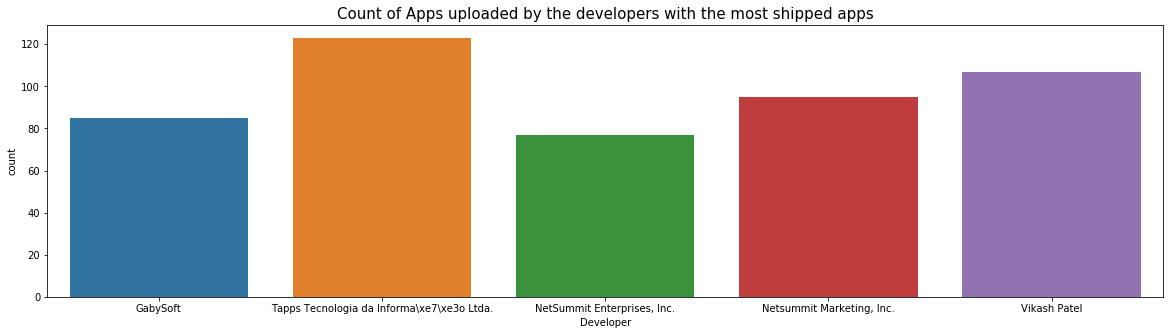

In [69]:
# top_5_devs_df.info()
n_user_rating = top_5_devs_df['Developer']
plt.figure(figsize=(20,5))
sns.countplot(n_user_rating)
plt.title("Count of apps uploaded by the developers with the most shipped apps",fontsize=15)
# sns.countplot(x='Developer', edgecolor="1", hue="Multiple Languages", data=top_5_devs_df)

### How to get each top developer's apps that received more than 1000 User Rating Count and received a 4.0 rating or greater

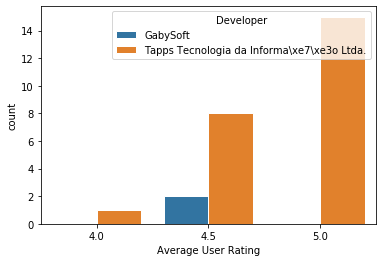

In [80]:
# top_5_devs_df[(top_5_devs_df["Average User Rating"] > 4) & (top_5_devs_df["User Rating Count"] > 1000)]
sns.countplot(x='Average User Rating', hue="Developer", edgecolor="1", data=top_5_devs_df[(top_5_devs_df["User Rating Count"] > 1000)])

In [280]:
def df_from_col_ratio(df, to_ratio_col, x_col):
    '''Get df with ratio of column based on all possible values or x_col and put it in a line graph'''
    to_ratio_values = [] #unique values of to_ratio_col from df
    x_col_values_dic = {} #{"Promoter": [], "Passive": [], "Detractor":[]} 
    for to_ratio_value in sorted(df[to_ratio_col].dropna().unique()): #loop through each unique values of to_ratio_col
        x_col_ratio_dic = conditional_prob(df, to_ratio_col, to_ratio_value, x_col)
        to_ratio_values.append(to_ratio_value) #append current location
        for key, value in x_col_ratio_dic.items(): #loop through each key,value pairs in dic received from conditional_prob
            if key in x_col_values_dic: #if dic's key has values already
                x_col_values_dic[key].append(value) #if key exist, append value to our list's key
            else:  #if dic's key is none...
                x_col_values_dic[key] = [value] #create the array with our value
    #Turn dic and array to dataframe
    df_new = pd.DataFrame(x_col_values_dic, index=to_ratio_values)
    return df_new

# columns = [column for column in df.columns if df[column].dtype == 'float64']
# top_5_devs_df.drop("ID", axis=1) #trying to remove ID column in the graph
# del top_5_devs_df['ID'] #delet ID column
# top_5_devs_df['Average User Rating'].plot.line()

In [281]:
# top_5_devs_df['User Rating Count'].plot.line()

Text(0.5, 1.0, 'Did High Rated Apps By Top Developers Supported Multiple Languages?')

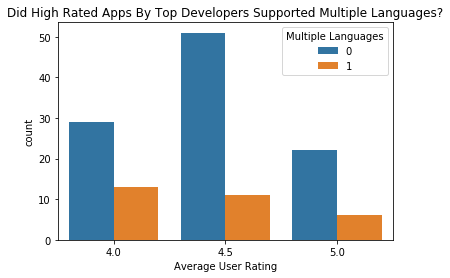

In [259]:
top_5_devs = top_5_devs_df[(top_5_devs_df["Average User Rating"] >= 4)]
plot = sns.countplot(x="Average User Rating", hue="Multiple Languages", data=top_5_devs)
plot.set_title("Did High Rated Apps By Top Developers Supported Multiple Languages?")

### How to get each developer's most User Rating Count apps

In [336]:
top_5_devs_df.loc[top_5_devs_df.groupby('Developer')["User Rating Count"].agg('idxmax')]

,URL,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date,Multiple Languages
1172,https://apps.apple.com/us/app/flippix-art-zoo/...,FlipPix Art - Zoo,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.5,3455.0,0.0,NaN,"""An old Japanese logic puzzle takes on a new l...",GabySoft,4+,EN,31571968.0,Games,"Games, Puzzle, Strategy, Entertainment",1/03/2012,7/03/2018,0
3227,https://apps.apple.com/us/app/doodle-connect-p...,Doodle Connect Pipe,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,3.5,59.0,0.0,2.99,Connect the dots! Connect the pipes to each co...,"NetSummit Enterprises, Inc.",4+,EN,15949824.0,Games,"Games, Strategy, Puzzle",7/02/2014,6/08/2014,0
3473,https://apps.apple.com/us/app/jewel-pop-ultima...,Jewel Pop: Ultimate Match Game,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,4.0,67.0,0.0,"2.99, 0.99, 3.99, 1.99","""Once you pop, it's hard to stop!\n\nThis chal...","Netsummit Marketing, Inc.",4+,"EN, FR, DE, JA, KO, ZH",33669120.0,Games,"Games, Strategy, Puzzle",4/04/2014,10/10/2014,1
7002,https://apps.apple.com/us/app/vlogger-go-viral...,Vlogger Go Viral - Tube Star,Clicker Idle Simulator,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,5.0,80407.0,0.0,"2.99, 1.99, 2.99, 4.99, 9.99, 5.99, 2.99, 5.99...","""Get ready to become the next Internet sensati...",Tapps Tecnologia da Informa\xe7\xe3o Ltda.,4+,"EN, FR, DE, PT, RU, ES, TR",138714112.0,Games,"Games, Entertainment, Strategy, Simulation",26/11/2015,24/07/2019,1
10042,https://apps.apple.com/us/app/farm-find-the-hi...,Farm Find The Hidden Objects Old Memory,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,1.5,5.0,0.0,NaN,Farm Find The Hidden Objects Old Memory is a n...,Vikash Patel,4+,EN,6553600.0,Games,"Games, Puzzle, Strategy, Entertainment",6/11/2016,6/11/2016,0


### Answers
- Tapps Tecnologia da Informa had most apps and user ratings
- Uploading more apps doesnt generally results to higher rating average or higher rating count

### Q5 Successful Apps Commonalities

Text(0.5, 1.0, 'Age Rating 10K Rating Counts')

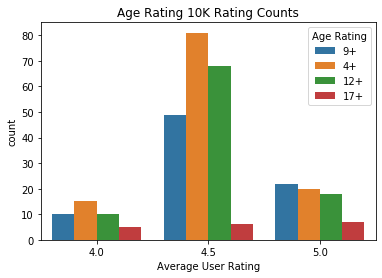

In [334]:
ten_k_rates = df[(df["Average User Rating"] >= 4) & (df["User Rating Count"] > 10000)]
plot = sns.countplot(x="Average User Rating", hue="Age Rating", data=ten_k_rates)
# plot = sns.countplot(x="Age Rating", hue="Average User Rating", data=top_5_devs)
plot.set_title("Age Rating 10K Rating Counts")

Text(0.5, 1.0, 'Age Rating 1K Rating Counts')

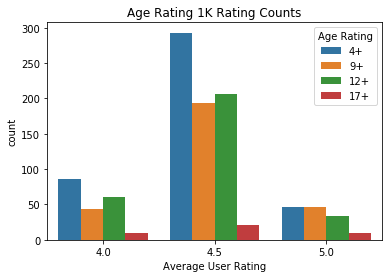

In [335]:
one_k_rates = df[(df["Average User Rating"] >= 4) & (df["User Rating Count"] > 1000)]
plot2 = sns.countplot(x="Average User Rating", hue="Age Rating", data=one_k_rates)
plot2.set_title("Age Rating 1K Rating Counts")

Text(0.5, 1.0, 'Free Apps Performs Better')

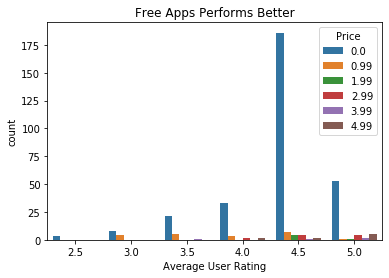

In [305]:
successful_apps = df[(df["User Rating Count"] > 10000) & (df["Price"] < 5)]
plot1 = sns.countplot(x="Average User Rating", hue="Price", data=successful_apps)
plot1.set_title("Free Apps Performs Better")

In [333]:
in_app_purchase = df["In-app Purchases"].dropna()
in_app_purchase_percent = len(in_app_purchase) / len(df)
print(str(round(in_app_purchase_percent * 100)), "% of Apps have In-App Purchases")

successful_in_app_purchase = ten_k_rates["In-app Purchases"].dropna()
successful_in_app_purchase_percent = len(successful_in_app_purchase) / len(ten_k_rates)
print(str(round(successful_in_app_purchase_percent * 100)), "% of Successfull Apps have In-App Purchases")

45 % of Apps have In-App Purchases
92 % of Successfull Apps have In-App Purchases


## Conclusions
- Strategy games are very popular and receiving mostly a 4.5 rating in the App Store
- Factors that can drive more downloads and higher user rating average
    - support multiple languages ***(To automate localization, check out [StringsUtility](https://github.com/SamuelFolledo/StringsUtility))***
    - include in-app purchases
    - Do not set Age Rating to 17+, anything below 17+ will result to more User Rating Count
    - Make your game free of course
    - Life span and constantly updating apps, as more apps doesn't result to more
    